## Step 1: Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import csv
import json
import random
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose

2024-12-04 12:54:12.870280: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 12:54:16.878786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 12:54:21.787322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 12:54:22.157082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 12:54:25.006970: I tensorflow/core/platform/cpu_feature_guar

## Step 2: Define parameters

In [2]:
DATASET = "electricity"
# Number of data sheets to be loaded
NUM_DATA_SHEETS = 10
# Number of models in the federated learning setup
NUM_CLIENTS = 30
NUM_CLIENTS_TEST = 6
NUM_CLIENTS = NUM_CLIENTS_TEST
# Number of previous time points used for forecasting the next point
LOOK_BACK = 7
# Number of epochs for training
EPOCHS = 60
# Number of client epochs
CLIENT_EPOCHS = 10
# Number of batch size
BATCH_SIZE = 32
# Interval at which to save weights
SAVE_INTERVAL = 1
# Initial learning rate
LEARNING_RATE = 0.01
# Train-test size
TRAIN_SIZE = 0.7
# Data dir
DATA_DIR = "data"
# Client update matrix dir
CLIENT_MATRIX_DIR = "client_matrix"
# FL output dir
FL_OUTPUT_DIR = "federated_output"
# General output dir
GENERAL_OUTPUT_DIR = "summary_output"
# Prefix
PREFIX = "avg"
# Missing rules
PERCENTAGE_MISSING_CLIENT = "01"
MISSING_MODE = "noadjacency"
MATRIX_MISSING_LENGTH = "10x10"
# Weight tracking directory
WEIGHT_TRACKING_DIR = f'weights_tracking_models/{DATASET}/{PREFIX}/{MATRIX_MISSING_LENGTH}/{MISSING_MODE}/{PERCENTAGE_MISSING_CLIENT}'

## Step 3: Set tf random seed

In [3]:
tf.random.set_seed(3)  # Set random seed for reproducibility

## Step 4: Define functions

In [4]:
def create_client_matrix(filename, rows=160, columns=100, missing_client_percentage=0.1, no_adjacent_missing=True):
    # Initialize the previous row as empty to enforce the no-adjacency rule
    prev_row = [''] * columns
    
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        for row_idx in range(rows):
            row = ['Y'] * columns
            if row_idx >= 2:
                N_count = int(columns * missing_client_percentage)
                
                # Ensure that 'N' is placed in positions not occupied by 'N' in the previous row
                if no_adjacent_missing:
                    possible_positions = [i for i in range(columns) if prev_row[i] != 'N']
                    N_positions = random.sample(possible_positions, min(N_count, len(possible_positions)))
                else:
                    N_positions = random.sample(range(columns), N_count)
                
                for pos in N_positions:
                    row[pos] = 'N'
            
            # Write the current row to the CSV file
            writer.writerow(row)
            
            # Update prev_row for the next iteration
            prev_row = row

# Function to load all sheets from an Excel file into a dictionary with error handling
def load_data(file_path, sheets):
    data_dict = {}
    for key, sheet in sheets.items():
        try:
            data_dict[key] = pd.read_excel(file_path, sheet_name=sheet)
            print(f"Loaded data for {key} from sheet {sheet}")
        except Exception as e:
            print(f"Failed to load data for {key} from sheet {sheet}: {e}")
    return data_dict

# Function to visualize data
def visualize_data(df, title, xlabel, ylabel):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set(rc={"figure.figsize": (15, 6)})
    sns.histplot(df["Daily Value"], bins=50, kde=True, color="blue")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Function to create and compile the model
def create_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(16, activation="sigmoid"))
    model.add(Dense(output_shape))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mse", "mae", "mape"]
    )
    return model

# Function to plot data
def plot_the_data(orig_plot, predict_train_plot, predict_test_plot, title):
    plt.figure(figsize=(15, 6))
    plt.plot(orig_plot, color="blue", label="Actual")
    plt.plot(predict_train_plot, color="red", label="Predicted on training")
    plt.plot(predict_test_plot, color="green", label="Predicted on testing")
    plt.legend()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (kWh)")
    plt.show()

# Data preparation functions
def scale_split_datasets(data, train_size, lookback):
    sc_X = StandardScaler()
    daily_consumption_scaled = sc_X.fit_transform(data.values.reshape(-1, 1))
    num_train = int(train_size * len(data))
    training_data = daily_consumption_scaled[:num_train]
    test_data = daily_consumption_scaled[num_train - lookback :]
    return training_data, test_data, sc_X

def create_rnn_dataset(data, lookback):
    data_x, data_y = [], []
    for i in range(len(data) - lookback - 1):
        a = data[i : (i + lookback), 0]
        data_x.append(a)
        data_y.append(data[i + lookback, 0])
    x = np.array(data_x)
    y = np.array(data_y)
    x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
    return x, y

def plot_data_preparation(data, predict_on_train, predict_on_test, lookback):
    total_size = len(predict_on_train) + len(predict_on_test)
    orig_data = data.to_numpy().reshape(len(data), 1)
    orig_plot = np.empty((total_size, 1))
    orig_plot[:, :] = np.nan
    orig_plot[:total_size, :] = orig_data[lookback:-2]
    predict_train_plot = np.empty((total_size, 1))
    predict_train_plot[:, :] = np.nan
    predict_train_plot[: len(predict_on_train), :] = predict_on_train
    predict_test_plot = np.empty((total_size, 1))
    predict_test_plot[:, :] = np.nan
    predict_test_plot[len(predict_on_train) : total_size, :] = predict_on_test
    return orig_plot, predict_train_plot, predict_test_plot

# Federated Learning Model Preparation
def create_train_test_dataset(df, lookback):
    df["Daily Value"] = df.iloc[:, 1:-1].sum(axis=1)
    sc_X = StandardScaler()
    daily_consumption = df["Daily Value"]
    num_train = int(TRAIN_SIZE * len(daily_consumption))
    daily_consumption_scaled = sc_X.fit_transform(
        daily_consumption.values.reshape(-1, 1)
    )
    training_set = daily_consumption_scaled[:num_train]
    x_train, y_train = create_rnn_dataset(training_set, lookback)
    test_data = daily_consumption_scaled[num_train - lookback :]
    x_test, y_test = create_rnn_dataset(test_data, lookback)
    return x_train, y_train, x_test, y_test, sc_X

def train_model(model, x_train, y_train, log_dir):
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    early_stopping = EarlyStopping(
        monitor="loss", min_delta=0.001, patience=5, verbose=1, mode="auto"
    )
    model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        callbacks=[tensorboard_callback, early_stopping],
        # callbacks=[tensorboard_callback],
    )

# Evaluate the models
def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.evaluate(x_train, y_train)
    model.evaluate(x_test, y_test)

# Federated learning aggregation sections
def federated_averaging(models, x_train, y_train, rounds=10):
    history_dict = {}
    for r in range(rounds):
        print(f"Round {r}:")
        history_dict[str(r)] = {}
        weights = [model.get_weights() for model in models]
        new_weights = [
            np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))
        ]
        for i in range(len(models)):
            models[i].set_weights(new_weights)
            history = models[i].fit(x_train, y_train, epochs=CLIENT_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
            history_dict[str(r)][str(i)] = history.history

    return history_dict

def save_weights_to_csv(model, filename):
    """Save the model weights to a CSV file."""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        for layer in model.weights:
            writer.writerow(layer.numpy().flatten())

def load_weights_from_csv(filename, model):
    """Load weights from a CSV file and set them to the model."""
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        new_weights = []
        for layer, row in zip(model.weights, reader):
            reshaped_weights = np.array(row, dtype=np.float32).reshape(layer.shape)
            new_weights.append(reshaped_weights)
        model.set_weights(new_weights)

def sum_weights_from_two_csvs(file1, file2, model):
    """Sum weights from two CSV files and set them to the model."""
    weights1 = []
    weights2 = []

    # Read weights from the first file
    with open(file1, 'r') as f1:
        reader1 = csv.reader(f1)
        weights1 = [np.array(row, dtype=np.float32) for row in reader1]

    # Read weights from the second file
    with open(file2, 'r') as f2:
        reader2 = csv.reader(f2)
        weights2 = [np.array(row, dtype=np.float32) for row in reader2]

    # Compute the sum of weights
    summed_weights = [0.2*w1 + 0.8*w2 for w1, w2 in zip(weights1, weights2)]

    # Reshape summed weights and set them to the model
    reshaped_weights = [
        weight.reshape(layer.shape) for weight, layer in zip(summed_weights, model.weights)
    ]
    model.set_weights(reshaped_weights)

def federated_weighing(models, x_train, y_train, client_matrix, round=10, has_weights_mechanism=False):
    history_dict = {}    
    for r in range(round):
        print(f"Round {r}:")
        history_dict[str(r)] = {}
        weights = [] #[model.get_weights() for model in models]
        for i in range(len(models)):
            if r >= 2 and client_matrix[r, i] == 'N':
                if has_weights_mechanism:
                    prev_csv_1 = f'{WEIGHT_TRACKING_DIR}/weights_tracking_model_client_{str(i)}_round_{str(r - 2)}.csv'
                    prev_csv_2 = f'{WEIGHT_TRACKING_DIR}/weights_tracking_model_client_{str(i)}_round_{str(r - 1)}.csv'
                    sum_weights_from_two_csvs(prev_csv_1, prev_csv_2, models[i])
                    print(f"Updated weights using the sum of round {r - 1} and {r - 2}")
                else:
                    zero_w = [0.0*np.random.rand(*w.shape) for w in models[i].get_weights()]
                    models[i].set_weights(zero_w)
            
            weights.append(models[i].get_weights())
        
        new_weights = [
            np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))
        ]
        for i in range(len(models)):
            models[i].set_weights(new_weights)
            history = models[i].fit(x_train, y_train, epochs=CLIENT_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
            history_dict[str(r)][str(i)] = history.history
            if has_weights_mechanism:
                # Save weights
                csv_file = f'{WEIGHT_TRACKING_DIR}/weights_tracking_model_client_{str(i)}_round_{str(r)}.csv'
                save_weights_to_csv(models[i], csv_file)
                print(f"Saved weights to {csv_file}")
    
    return history_dict

# Save results to json file
def to_json(filepath, history_dict):
    with open(filepath, "w") as f:
        json.dump(history_dict, f)

# Predictions and plotting
def inverse_transform_predictions(predictions, scaler):
    return scaler.inverse_transform(predictions)

# Plot predictions
def prepare_and_plot(data, train_predictions, test_predictions, lookback, title):
    orig_plot, train_plot, test_plot = plot_data_preparation(
        data, train_predictions, test_predictions, lookback
    )
    plot_the_data(orig_plot, train_plot, test_plot, title)

## Step 5.1: Load dataset

In [5]:
# Define the file path and sheet names with their corresponding keys
file_path = f"../{DATA_DIR}/{DATASET}/standard_{DATASET}.xlsx"
sheets = {}
for i in range(NUM_DATA_SHEETS):
    sheets[f'client_{str(i)}'] = f'Sheet_{str(i + 2)}'

# Load the data
dictionary = load_data(file_path, sheets)

Loaded data for client_0 from sheet Sheet_2
Loaded data for client_1 from sheet Sheet_3
Loaded data for client_2 from sheet Sheet_4
Loaded data for client_3 from sheet Sheet_5
Loaded data for client_4 from sheet Sheet_6
Loaded data for client_5 from sheet Sheet_7
Loaded data for client_6 from sheet Sheet_8
Loaded data for client_7 from sheet Sheet_9
Loaded data for client_8 from sheet Sheet_10
Loaded data for client_9 from sheet Sheet_11


In [6]:
dictionary['client_1'].describe()

,Hour 0,Hour 1,Hour 2,Hour 3,Hour 4,Hour 5,Hour 6,Hour 7,Hour 8,Hour 9,...,Hour 14,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,...,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,105.033790,101.105839,90.950730,86.468978,85.630474,86.587591,89.946168,101.787409,126.611314,131.030109,...,121.752737,117.712591,111.387774,109.381387,112.209854,120.953467,132.374088,135.888686,124.666058,110.639599
std,19.788142,21.597770,16.701115,13.953051,14.650614,13.929752,14.642773,20.249662,25.087653,22.420636,...,21.323813,20.256719,19.278071,18.583406,19.976510,21.447411,23.330906,23.594412,23.103851,18.993357
min,26.000000,20.000000,0.000000,12.000000,12.000000,12.000000,12.000000,21.000000,31.000000,46.000000,...,41.000000,38.000000,34.000000,32.000000,32.000000,34.000000,38.000000,52.000000,39.000000,33.000000
25%,96.000000,92.000000,84.000000,80.000000,80.000000,80.000000,85.000000,91.000000,106.000000,114.000000,...,112.000000,110.000000,104.000000,102.000000,104.000000,110.000000,117.750000,120.000000,111.000000,101.000000
50%,102.000000,97.000000,92.000000,90.000000,88.000000,89.000000,92.000000,98.000000,133.000000,133.000000,...,121.000000,119.000000,113.000000,111.000000,113.000000,119.000000,129.000000,132.000000,120.000000,109.000000
75%,115.000000,111.000000,98.000000,94.000000,92.000000,93.000000,97.000000,112.250000,146.000000,147.000000,...,135.000000,131.000000,122.000000,119.000000,122.000000,135.000000,150.000000,152.250000,137.000000,119.000000
max,199.000000,172.000000,188.000000,135.000000,118.000000,118.000000,124.000000,161.000000,179.000000,182.000000,...,210.000000,265.000000,210.000000,176.000000,250.000000,172.000000,198.000000,227.000000,296.000000,172.000000


## Step 5.2: Example for client_1 data

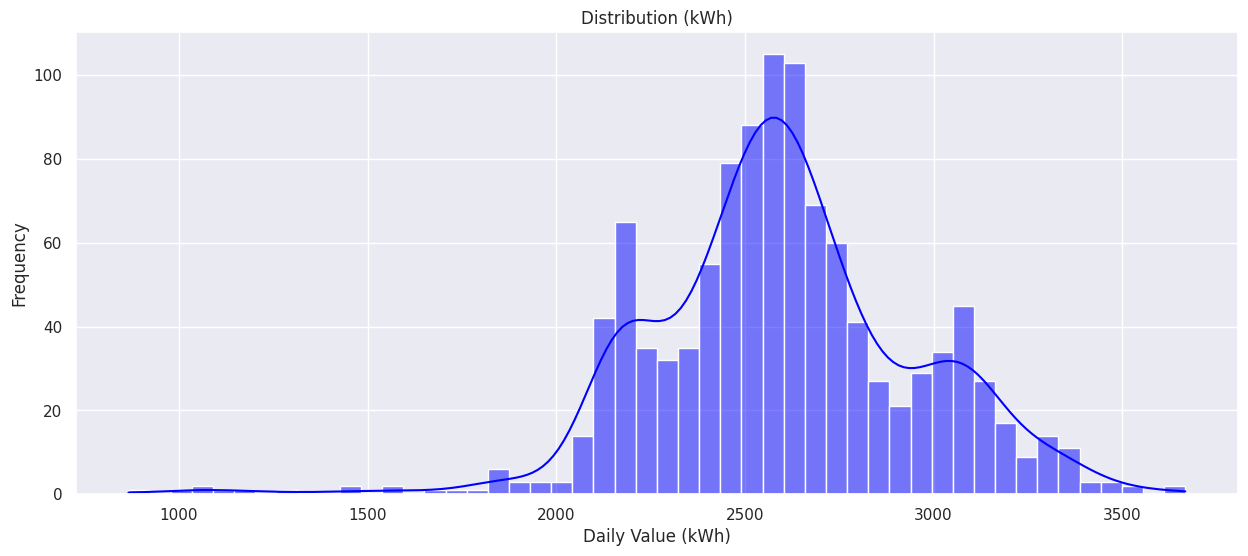

In [7]:
client_name = "client_1"
df = dictionary[client_name]
df["Daily Value"] = df.iloc[:, 1:-1].sum(axis=1)

# Visualize data
visualize_data(df, "Distribution (kWh)", "Daily Value (kWh)", "Frequency")

## Step 5.3: Split train/test data

In [8]:
# Scale and split data
training_set, test_data, sc_X = scale_split_datasets(
    df["Daily Value"], TRAIN_SIZE, LOOK_BACK
)
x_train, y_train = create_rnn_dataset(training_set, LOOK_BACK)
x_test, y_test = create_rnn_dataset(test_data, LOOK_BACK)

## Step 5.4: Create models

In [9]:
# Create and train the model
ts_model = create_model(input_shape=(1, LOOK_BACK), output_shape=1)
log_dir = f"logs/{PREFIX}fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

ts_model.fit(
    x_train,
    y_train,
    epochs=CLIENT_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[tensorboard_callback],
)

# Evaluate model
ts_model.evaluate(x_test, y_test, verbose=1)
predict_on_train = ts_model.predict(x_train)
predict_on_test = ts_model.predict(x_test)

I0000 00:00:1733313298.748995 1969482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-04 12:55:02.844213: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/mnt/d/shinProjects/FLDT/.venv39/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.8681 - mae: 1.1521 - mape: 991.6042 - mse: 1.8681
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1815 - mae: 0.8909 - mape: 746.1569 - mse: 1.1815 
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6723 - mae: 0.6395 - mape: 532.3506 - mse: 0.6723 
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4403 - mae: 0.4615 - mape: 380.7217 - mse: 0.4403
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3757 - mae: 0.3871 - mape: 307.3771 - mse: 0.3757
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3572 - mae: 0.3671 - mape: 281.9703 - mse: 0.3572
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3469 - mae: 0.3614 - mape: 276.8382 - mse: 0.3469
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3379 - mae: 0.3569 - mape: 276.4338 - mse: 0.3379
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3292 - mae: 0.3520 - mape: 274.5464 - mse: 0.3292
Epoch 1

## Step 5.5: Try plotting

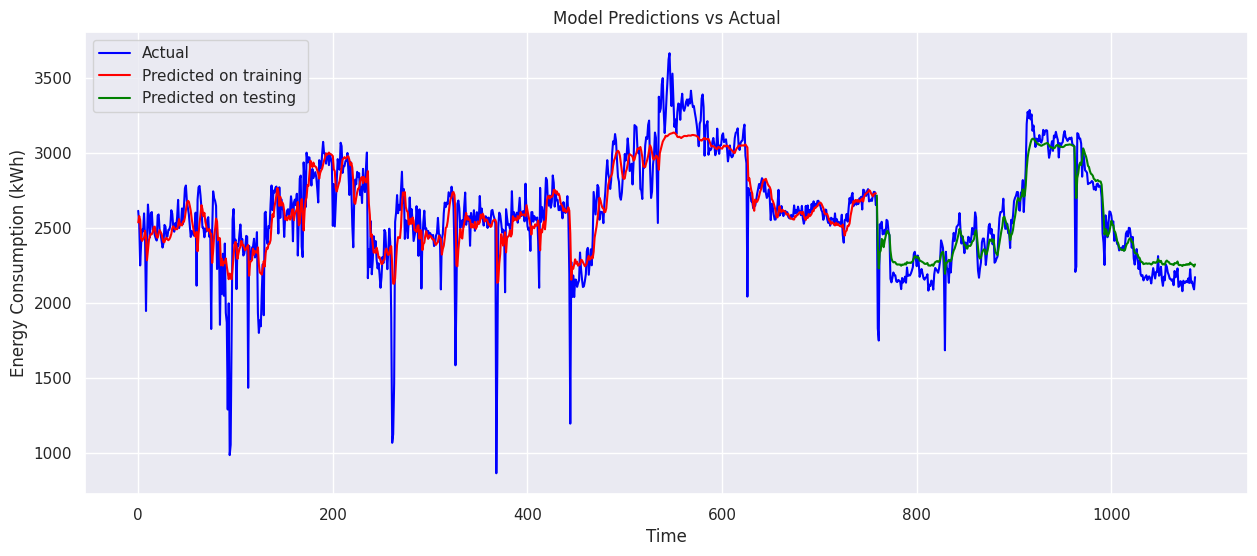

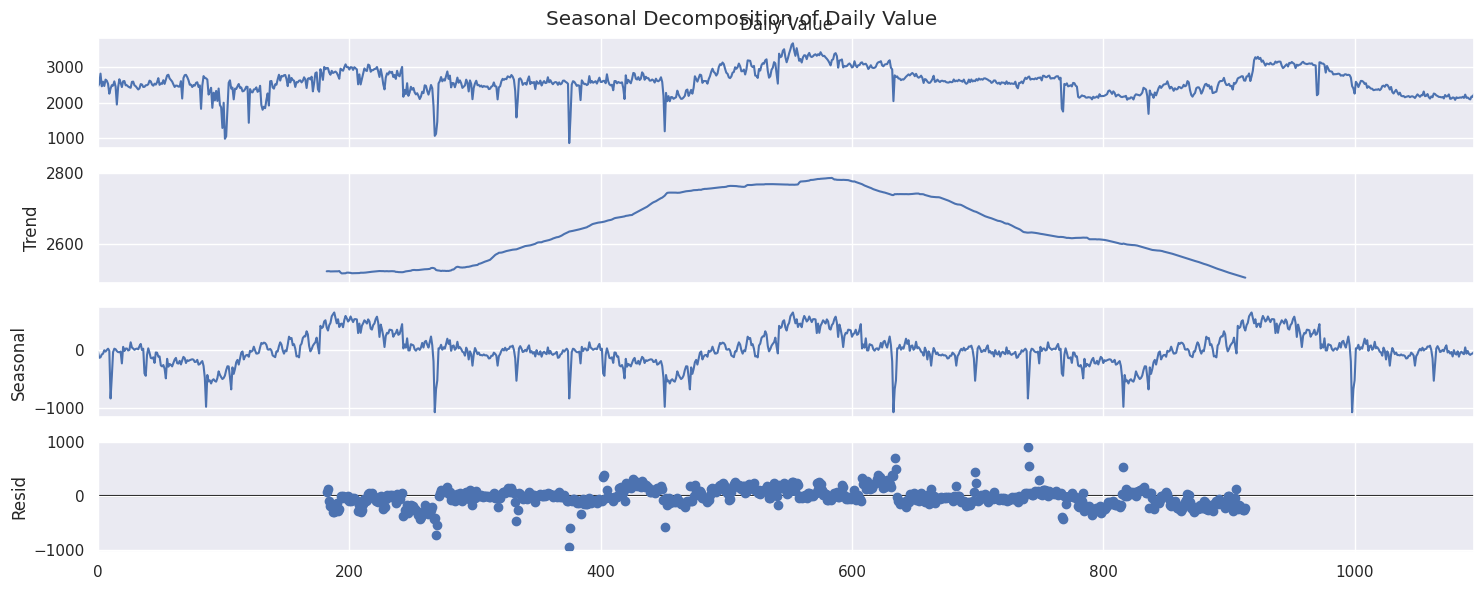

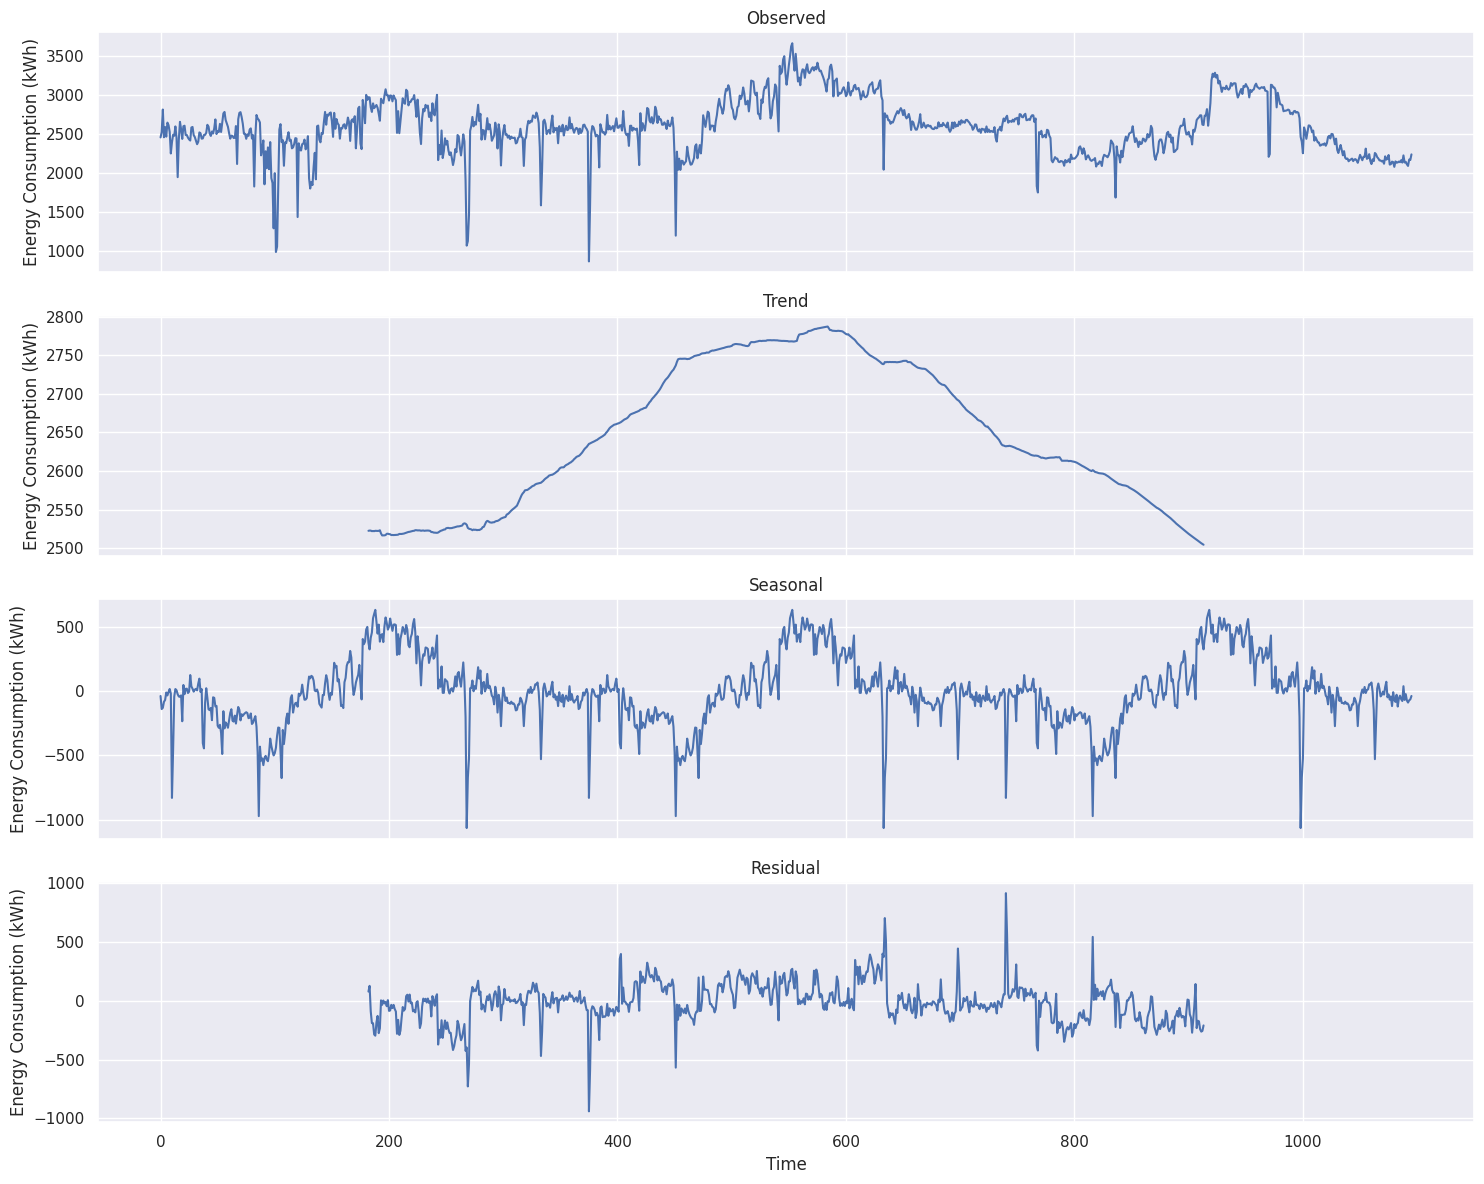

In [10]:
predict_on_train = sc_X.inverse_transform(predict_on_train)
predict_on_test = sc_X.inverse_transform(predict_on_test)

# Plot predictions
plot_original, plot_train, plot_test = plot_data_preparation(
    df["Daily Value"], predict_on_train, predict_on_test, LOOK_BACK
)
plot_the_data(plot_original, plot_train, plot_test, "Model Predictions vs Actual")

# Seasonal decomposition
result = seasonal_decompose(df["Daily Value"], model="additive", period=365)
result.plot()
plt.suptitle("Seasonal Decomposition of Daily Value")
plt.show()

# Enhanced visualization of seasonal decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=axes[0], title="Observed")
result.trend.plot(ax=axes[1], title="Trend")
result.seasonal.plot(ax=axes[2], title="Seasonal")
result.resid.plot(ax=axes[3], title="Residual")
for ax in axes:
    ax.set_ylabel("Energy Consumption (kWh)")
axes[3].set_xlabel("Time")
plt.tight_layout()
plt.show()

## Step 5.6: Try saving to excel file

In [11]:
# Save the residuals to an Excel file
os.makedirs(f'{GENERAL_OUTPUT_DIR}/{client_name}', exist_ok=True)
pd.DataFrame(result.resid).to_excel(
    f"{GENERAL_OUTPUT_DIR}/{client_name}/{PREFIX}_client.xlsx", sheet_name="Decomposition_Residuals"
)

# Summary statistics
residual_stats = pd.DataFrame(
    {
        "Mean": [result.resid.mean()],
        "Median": [result.resid.median()],
        "Standard Deviation": [result.resid.std()],
        "Max": [result.resid.max()],
        "Min": [result.resid.min()],
    }
)

# Save summary statistics
residual_stats.to_excel(f"{GENERAL_OUTPUT_DIR}/{client_name}/{PREFIX}residual_statistics.xlsx", index=False)

# Display summary statistics
print("Summary Statistics of Residuals:")
print(residual_stats)

Summary Statistics of Residuals:
        Mean     Median  Standard Deviation         Max         Min
0 -14.271409 -13.576204          164.780598  910.791604 -939.334423


## Step 5.7: Evaluate models

In [12]:
# Evaluation metrics
metrics = ts_model.evaluate(x_test, y_test, verbose=1)
metrics_df = pd.DataFrame([metrics], columns=["Loss", "MSE", "MAE", "MAPE"])

# Save evaluation metrics
metrics_df.to_excel(f"{GENERAL_OUTPUT_DIR}/{client_name}/{PREFIX}evaluation_metrics.xlsx", index=False)

# Display evaluation metrics
print("Evaluation Metrics:")
print(metrics_df)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2104 - mae: 0.3064 - mape: 110.2701 - mse: 0.2104
Evaluation Metrics:
      Loss      MSE       MAE        MAPE
0  0.16655  0.16655  0.282674  102.697227


## Step 5.8: Create train/test set

In [13]:
train_test_dataset = []
for i in range(NUM_DATA_SHEETS):
    _x_train, _y_train, _x_test, _y_test, _sc_cl = create_train_test_dataset(dictionary[f'client_{str(i)}'], LOOK_BACK)
    train_test_dataset.append((_x_train, _y_train, _x_test, _y_test, _sc_cl))

## Step 5.9: Create model arrays

In [14]:
model_arr = []
for i in range(NUM_DATA_SHEETS):
    _model = create_model(input_shape=(1, LOOK_BACK), output_shape=1)
    model_arr.append(_model)

/mnt/d/shinProjects/FLDT/.venv39/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Step 5.10: Train models

In [15]:
for i in range(NUM_CLIENTS):
    _x_train, _y_train, _, _, _ = train_test_dataset[i]
    train_model(model_arr[i], _x_train, _y_train, f'logs/fit/{PREFIX}{str(i)}')

Epoch 1/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7928 - mae: 0.8913 - mape: 131.1981 - mse: 1.7928   
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0263 - mae: 0.6251 - mape: 84.8204 - mse: 1.0263 
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4929 - mae: 0.4311 - mape: 64.2799 - mse: 0.4929 
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3207 - mae: 0.3316 - mape: 62.3633 - mse: 0.3207 
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2868 - mae: 0.3113 - mape: 64.0371 - mse: 0.2868 
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2651 - mae: 0.3076 - mape: 63.7902 - mse: 0.2651 
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2433 - mae: 0.2993 - mape: 62.2110 - mse: 0.2433 
Epoch 8/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2222 - mae: 0.2859 - mape: 59.9731 - mse: 0.2222 
Epoch 9/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2031 - mae: 0.2715 - mape: 57.7131 - mse: 0.2031 
Epoch 1

## Step 5.11: Evaluate models

In [16]:
for i in range(NUM_CLIENTS):
    _x_train, _y_train, _x_test, _y_test, _ = train_test_dataset[i]
    evaluate_model(model_arr[i], _x_train, _y_train, _x_test, _y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1296 - mae: 0.2188 - mape: 55.3936 - mse: 0.1296   
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1938 - mae: 0.2410 - mape: 45.9064 - mse: 0.1938 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3107 - mae: 0.3455 - mape: 445.2629 - mse: 0.3107   
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1453 - mae: 0.2135 - mape: 76.7635 - mse: 0.1453 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3995 - mae: 0.2462 - mape: 146.0319 - mse: 0.3995  
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5723e-04 - mae: 0.0088 - mape: 3.5852 - mse: 1.5723e-04 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1253 - mae: 0.2667 - mape: 120.6075 - mse: 0.1253  
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1393 - mae: 0.2837 - mape: 1081.3125 - mse: 0.1393
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0900 - mae: 0.2293 - mape: 223.3430 - mse: 0.0900 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1141 - mae: 0.2640 - mape: 70.5860 - mse: 

## Step 6: Execute the FedAvg

In [18]:
# create_client_matrix(f'{CLIENT_MATRIX_DIR}/client_matrix.csv', missing_client_percentage=0.1, no_adjacent_missing=True)
client_matrix = np.loadtxt(f'../{CLIENT_MATRIX_DIR}/client_matrix_{MATRIX_MISSING_LENGTH}_{PERCENTAGE_MISSING_CLIENT}_{MISSING_MODE}.csv', delimiter=',', dtype=str)
if not os.path.exists(WEIGHT_TRACKING_DIR):
    os.makedirs(WEIGHT_TRACKING_DIR)

history_client_avg_dict = {}
for i in range(len(model_arr)):
    _x_train, _y_train, _, _, _ = train_test_dataset[i]
    print(f"Processing turn {i}...")
    hist_dict_avg = federated_weighing(model_arr, _x_train, _y_train, client_matrix, has_weights_mechanism=False)
    history_client_avg_dict[f'client_{str(i)}'] = hist_dict_avg

Processing turn 0...
Round 0:
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9961 - mae: 0.8866 - mape: 120.2600 - mse: 0.9961 
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8765 - mae: 0.8096 - mape: 103.9597 - mse: 0.8765 
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6413 - mae: 0.6884 - mape: 91.8070 - mse: 0.6413 
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4410 - mae: 0.5339 - mape: 79.5090 - mse: 0.4410 
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3362 - mae: 0.4081 - mape: 71.4703 - mse: 0.3362 
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2897 - mae: 0.3479 - mape: 69.0534 - mse: 0.2897 
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2554 - mae: 0.3191 - mape: 66.6262 - mse: 0.2554 
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2229 - mae: 0.2960 - mape: 62.3930 - mse: 0.2229 
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1963 - mae: 0.2764 - mape: 5

In [ ]:
history_client_save_dir = f"model_history/{DATASET}/{PREFIX}/clients/{MATRIX_MISSING_LENGTH}/{PERCENTAGE_MISSING_CLIENT}/{MISSING_MODE}"
if not os.path.exists(history_client_save_dir):
    os.makedirs(history_client_save_dir)

to_json(f"{history_client_save_dir}/losses_rmses.json", history_client_avg_dict)

In [ ]:
# Get loss of central model after training all round with all clients
avg_central_x_train, avg_central_y_train, avg_central_x_test, avg_central_y_test, _ = train_test_dataset[0]
avg_central_model = create_model(input_shape=(1, LOOK_BACK), output_shape=1)
weights = [model.get_weights() for model in model_arr]
new_weights = [
            np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))
        ]
avg_central_model.set_weights(new_weights)
central_history = avg_central_model.fit(avg_central_x_train, avg_central_y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

losses = central_history.history['loss']
rmses = [x**(1/2) for x in central_history.history['mse']]

losses_rmses_dict = {
    "losses": losses,
    "rmses": rmses
}

In [ ]:
from sklearn.metrics import mean_squared_error
avg_central_predictions = avg_central_model.predict(avg_central_x_test)
print("Central model prediction/test RMSE: {}".format((mean_squared_error(avg_central_y_test, avg_central_predictions)**(1/2))))

In [ ]:
history_central_save_dir = f"model_history/{DATASET}/{PREFIX}/central/{MATRIX_MISSING_LENGTH}/{PERCENTAGE_MISSING_CLIENT}/{MISSING_MODE}"
if not os.path.exists(history_central_save_dir):
    os.makedirs(history_central_save_dir)

to_json(f"{history_central_save_dir}/losses_rmses.json", losses_rmses_dict)

In [ ]:
# Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, label=f'Central Model Training RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training Loss for Central Model')
plt.show()

# RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rmses) + 1), rmses, label=f'Central Model Training RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title(f'Training Loss for Central Model')
plt.show()

In [ ]:
train_predictions_arr = []
for i in range(NUM_CLIENTS):
    _x_train, _y_train, _x_test, _y_test, _sc_cl = train_test_dataset[i]
    _train_predictions = inverse_transform_predictions(model_arr[i].predict(_x_train), _sc_cl)
    train_predictions_arr.append(_train_predictions)

In [ ]:
test_predictions_arr = []
for i in range(NUM_CLIENTS):
    _x_train, _y_train, _x_test, _y_test, _sc_cl = train_test_dataset[i]
    _test_predictions = inverse_transform_predictions(model_arr[i].predict(_x_test), _sc_cl)
    test_predictions_arr.append(_test_predictions)

In [ ]:
for i in range(NUM_CLIENTS):
    prepare_and_plot(
        dictionary[f'client_{i}']['Daily Value'],
        train_predictions_arr[i],
        test_predictions_arr[i],
        LOOK_BACK,
        f"FL Model - Client {i}"
    )

In [ ]:
# Save the predictions
output_dir = f"{FL_OUTPUT_DIR}/{PREFIX}federated"
os.makedirs(output_dir, exist_ok=True)

predictions_files = {}
for i in range(NUM_CLIENTS):
    predictions_files[f'client{i}_test_predictions'] = test_predictions_arr[i]
    predictions_files[f'client{i}_train_predictions'] = train_predictions_arr[i]
    predictions_files[f'client{i}_original'] = dictionary[f'client_{i}']['Daily Value']

for filename, data in predictions_files.items():
    pd.DataFrame(data).to_excel(f"{output_dir}/{PREFIX}{filename}.xlsx")